In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import random
import math
from torch.utils.tensorboard import SummaryWriter
from collections import deque, namedtuple
import time
import gym


def weight_init(layers):
    for layer in layers:
        torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

In [2]:
class QR_DQN(nn.Module):
    def __init__(self, state_size, action_size,layer_size, n_step, seed, N, layer_type="ff"):
        super(QR_DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_shape = state_size
        self.action_size = action_size
        self.N = N

        self.head_1 = nn.Linear(self.input_shape[0], layer_size)
        self.ff_1 = nn.Linear(layer_size, layer_size)
        self.ff_2 = nn.Linear(layer_size, action_size*N)
        weight_init([self.head_1, self.ff_1])


    
    def forward(self, input):
        """
        
        """
        x = torch.relu(self.head_1(input))
        x = torch.relu(self.ff_1(x))
        out = self.ff_2(x)
        
        return out.view(input.shape[0], self.N, self.action_size)
    def get_action(self,input):
        x = self.forward(input)
        return x.mean(dim=1)

In [3]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device, seed, gamma, n_step=1):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.n_step = n_step
        self.n_step_buffer = deque(maxlen=self.n_step)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        #print("before:", state,action,reward,next_state, done)
        self.n_step_buffer.append((state, action, reward, next_state, done))
        if len(self.n_step_buffer) == self.n_step:
            state, action, reward, next_state, done = self.calc_multistep_return()
            #print("after:",state,action,reward,next_state, done)
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)
    
    def calc_multistep_return(self):
        Return = 0
        for idx in range(self.n_step):
            Return += self.gamma**idx * self.n_step_buffer[idx][2]
        
        return self.n_step_buffer[0][0], self.n_step_buffer[0][1], Return, self.n_step_buffer[-1][3], self.n_step_buffer[-1][4]
        
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [4]:
class DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 Network,
                 layer_size,
                 n_step,
                 BATCH_SIZE,
                 BUFFER_SIZE,
                 LR,
                 TAU,
                 GAMMA,
                 UPDATE_EVERY,
                 device,
                 seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            Network (str): dqn network type
            layer_size (int): size of the hidden layer
            BATCH_SIZE (int): size of the training batch
            BUFFER_SIZE (int): size of the replay memory
            LR (float): learning rate
            TAU (float): tau for soft updating the network weights
            GAMMA (float): discount factor
            UPDATE_EVERY (int): update frequency
            device (str): device that is used for the compute
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.TAU = TAU
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.BATCH_SIZE = BATCH_SIZE
        self.Q_updates = 0
        self.n_step = n_step
        self.N = 32
        self.quantile_tau = torch.FloatTensor([i/self.N for i in range(1,self.N+1)]).to(device)

        self.action_step = 4
        self.last_action = None

        # Q-Network
        self.qnetwork_local = QR_DQN(state_size, action_size,layer_size, n_step, seed, self.N).to(device)
        self.qnetwork_target = QR_DQN(state_size, action_size,layer_size, n_step, seed, self.N).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        print(self.qnetwork_local)
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, self.device, seed, self.GAMMA, n_step)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, writer):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                self.Q_updates += 1
                writer.add_scalar("Q_loss", loss, self.Q_updates)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy. Acting only every 4 frames!
        
        Params
        ======
            frame: to adjust epsilon
            state (array_like): current state
            
        """

        if self.action_step == 4:
            state = np.array(state)

            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local.get_action(state)
            self.qnetwork_local.train()

            # Epsilon-greedy action selection
            if random.random() > eps: # select greedy action if random number is higher than epsilon or noisy network is used!
                action = np.argmax(action_values.cpu().data.numpy())
                self.last_action = action
                return action
            else:
                action = random.choice(np.arange(self.action_size))
                self.last_action = action 
                return action
            #self.action_step = 0
        else:
            self.action_step += 1
            return self.last_action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().cpu() #.max(2)[0].unsqueeze(1) #(batch_size, 1, N)
        action_indx = torch.argmax(Q_targets_next.mean(dim=1), dim=1, keepdim=True)

        Q_targets_next = Q_targets_next.gather(2, action_indx.unsqueeze(-1).expand(self.BATCH_SIZE, self.N, 1)).transpose(1,2)

        assert Q_targets_next.shape == (self.BATCH_SIZE,1, self.N)
        # Compute Q targets for current states 
        Q_targets = rewards.unsqueeze(-1) + (self.GAMMA**self.n_step * Q_targets_next.to(self.device) * (1 - dones.unsqueeze(-1)))
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(2, actions.unsqueeze(-1).expand(self.BATCH_SIZE, self.N, 1))
        # Compute loss
        td_error = Q_targets - Q_expected
        assert td_error.shape == (self.BATCH_SIZE, self.N, self.N), "wrong td error shape"
        huber_l = calculate_huber_loss(td_error, 1.0)
        quantil_l = abs(self.quantile_tau -(td_error.detach() < 0).float()) * huber_l / 1.0

        loss = quantil_l.sum(dim=1).mean(dim=1) # , keepdim=True if per weights get multipl
        loss = loss.mean()
        # Minimize the loss
        loss.backward()
        #clip_grad_norm_(self.qnetwork_local.parameters(),1)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)
        return loss.detach().cpu().numpy()            

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data)
            
def calculate_huber_loss(td_errors, k=1.0):
    """
    Calculate huber loss element-wisely depending on kappa k.
    """
    loss = torch.where(td_errors.abs() <= k, 0.5 * td_errors.pow(2), k * (td_errors.abs() - 0.5 * k))
    assert loss.shape == (td_errors.shape[0], 32, 32), "huber loss has wrong shape"
    return loss

def eval_runs(eps, frame):
    """
    Makes an evaluation run with the current epsilon
    """
    env = gym.make("CartPole-v0")
    reward_batch = []
    for i in range(5):
        state = env.reset()
        rewards = 0
        while True:
            action = agent.act(state, eps)
            state, reward, done, _ = env.step(action)
            rewards += reward
            if done:
                break
        reward_batch.append(rewards)
        
    writer.add_scalar("Reward", np.mean(reward_batch), frame)

In [5]:
from tqdm import tqdm
QR=[]
def run(frames=1000, eps_fixed=False, eps_frames=1e6, min_eps=0.01):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    output_history = []
    frame = 0
    if eps_fixed:
        eps = 0
    else:
        eps = 1
    eps_start = 1
    i_episode = 1
    state = env.reset()
    score = 0                  
    for frame in tqdm(range(1, frames+1)):

        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done, writer)
        state = next_state
        score += reward
        # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
        if eps_fixed == False:
            if frame < eps_frames:
                eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
            else:
                eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)

        # evaluation runs
        if frame % 1000 == 0:
            eval_runs(eps, frame)
        
        if done:
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            writer.add_scalar("Average100", np.mean(scores_window), frame)
            output_history.append(np.mean(scores_window))
            print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
            i_episode +=1 
            state = env.reset()
            score = 0  
            QR.append([i_episode,frame,np.mean(scores_window)])

    return output_history


if __name__ == "__main__":
    
    writer = SummaryWriter("runs/"+"DQN_LL_new_1")
    seed = 1
    BUFFER_SIZE = 100000
    BATCH_SIZE = 32
    GAMMA = 0.99
    TAU = 1e-2
    LR = 1e-3
    UPDATE_EVERY = 1
    n_step = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using ", device)




    np.random.seed(seed)
    env = gym.make("CartPole-v0")

    env.seed(seed)
    action_size     = env.action_space.n
    state_size = env.observation_space.shape

    agent = DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        Network="DDQN",
                        layer_size=256,
                        n_step=n_step,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)



    # set epsilon frames to 0 so no epsilon exploration
    eps_fixed = False

    t0 = time.time()
    final_average100 = run(frames = 45000, eps_fixed=eps_fixed, eps_frames=5000, min_eps=0.025)
    t1 = time.time()
    
    print("Training time: {}min".format(round((t1-t0)/60,2)))
    torch.save(agent.qnetwork_local.state_dict(), "DQN"+".pth")


  0%|                                                                              | 46/45000 [00:00<01:39, 452.27it/s]

Using  cpu
QR_DQN(
  (head_1): Linear(in_features=4, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=64, bias=True)
)


  0%|▏                                                                             | 92/45000 [00:00<03:02, 246.55it/s]

Episode 2	Frame 93 	Average Score: 46.50

  0%|▏                                                                            | 122/45000 [00:00<03:34, 209.71it/s]

Episode 3	Frame 109 	Average Score: 36.33

  0%|▎                                                                            | 169/45000 [00:00<03:40, 202.91it/s]

Episode 4	Frame 152 	Average Score: 38.00

  0%|▎                                                                            | 213/45000 [00:01<03:49, 194.89it/s]

Episode 5	Frame 193 	Average Score: 38.60

  1%|▍                                                                            | 253/45000 [00:01<03:58, 187.41it/s]

Episode 8	Frame 268 	Average Score: 33.50

  1%|▌                                                                            | 315/45000 [00:01<03:51, 192.66it/s]

Episode 11	Frame 327 	Average Score: 29.73

  1%|▌                                                                            | 335/45000 [00:01<04:15, 174.52it/s]

Episode 12	Frame 341 	Average Score: 28.42

  1%|▋                                                                            | 391/45000 [00:02<04:24, 168.67it/s]

Episode 13	Frame 363 	Average Score: 27.92

  1%|▋                                                                            | 429/45000 [00:02<04:22, 169.69it/s]

Episode 15	Frame 412 	Average Score: 27.47

  1%|▊                                                                            | 469/45000 [00:02<04:08, 179.31it/s]

Episode 17	Frame 470 	Average Score: 27.65

  1%|▊                                                                            | 507/45000 [00:02<04:05, 181.57it/s]

Episode 18	Frame 494 	Average Score: 27.44

  1%|▉                                                                            | 563/45000 [00:03<04:14, 174.72it/s]

Episode 19	Frame 547 	Average Score: 28.79

  2%|█▏                                                                           | 710/45000 [00:03<04:07, 178.69it/s]

Episode 21	Frame 716 	Average Score: 34.10

  2%|█▎                                                                           | 763/45000 [00:04<04:27, 165.14it/s]

Episode 22	Frame 737 	Average Score: 33.50

  2%|█▍                                                                           | 813/45000 [00:04<04:40, 157.71it/s]

Episode 25	Frame 827 	Average Score: 33.08

  2%|█▍                                                                           | 844/45000 [00:04<05:04, 144.82it/s]

Episode 26	Frame 839 	Average Score: 32.27

  2%|█▌                                                                           | 891/45000 [00:05<04:53, 150.05it/s]

Episode 28	Frame 893 	Average Score: 31.89

  2%|█▌                                                                           | 924/45000 [00:05<04:47, 153.27it/s]

Episode 30	Frame 928 	Average Score: 30.93

  2%|█▋                                                                           | 975/45000 [00:05<04:42, 155.90it/s]

Episode 32	Frame 983 	Average Score: 30.72

  2%|█▋                                                                          | 1022/45000 [00:05<05:21, 136.72it/s]

Episode 34	Frame 1031 	Average Score: 30.32

  2%|█▊                                                                          | 1069/45000 [00:06<05:04, 144.25it/s]

Episode 35	Frame 1056 	Average Score: 30.17

  2%|█▉                                                                          | 1115/45000 [00:06<04:54, 148.93it/s]

Episode 38	Frame 1110 	Average Score: 29.21

  3%|█▉                                                                          | 1147/45000 [00:06<04:44, 153.91it/s]

Episode 40	Frame 1151 	Average Score: 28.77

  3%|█▉                                                                          | 1179/45000 [00:06<04:54, 148.74it/s]

Episode 42	Frame 1175 	Average Score: 27.98

  3%|██                                                                          | 1211/45000 [00:07<04:55, 148.22it/s]

Episode 43	Frame 1199 	Average Score: 27.88

  3%|██▏                                                                         | 1272/45000 [00:07<04:56, 147.40it/s]

Episode 44	Frame 1249 	Average Score: 28.39

  3%|██▏                                                                         | 1305/45000 [00:07<04:48, 151.38it/s]

Episode 46	Frame 1305 	Average Score: 28.37

  3%|██▎                                                                         | 1370/45000 [00:08<04:49, 150.47it/s]

Episode 48	Frame 1355 	Average Score: 28.23

  3%|██▍                                                                         | 1439/45000 [00:08<04:34, 158.71it/s]

Episode 50	Frame 1443 	Average Score: 28.86

  3%|██▍                                                                         | 1471/45000 [00:08<04:44, 152.97it/s]

Episode 51	Frame 1457 	Average Score: 28.57

  3%|██▌                                                                         | 1553/45000 [00:09<04:56, 146.75it/s]

Episode 52	Frame 1532 	Average Score: 29.46

  4%|██▋                                                                         | 1599/45000 [00:09<04:57, 145.85it/s]

Episode 54	Frame 1601 	Average Score: 29.65

  4%|██▊                                                                         | 1668/45000 [00:10<04:37, 156.30it/s]

Episode 56	Frame 1665 	Average Score: 29.73

  4%|██▉                                                                         | 1714/45000 [00:10<05:09, 139.73it/s]

Episode 59	Frame 1723 	Average Score: 29.20

  4%|███                                                                         | 1786/45000 [00:11<05:23, 133.67it/s]

Episode 61	Frame 1791 	Average Score: 29.36

  4%|███                                                                         | 1800/45000 [00:11<05:23, 133.34it/s]

Episode 62	Frame 1809 	Average Score: 29.18

  4%|███                                                                         | 1843/45000 [00:11<05:29, 130.99it/s]

Episode 64	Frame 1846 	Average Score: 28.84

  4%|███▏                                                                        | 1897/45000 [00:12<05:36, 128.07it/s]

Episode 66	Frame 1892 	Average Score: 28.67

  4%|███▏                                                                        | 1924/45000 [00:12<05:29, 130.75it/s]

Episode 67	Frame 1907 	Average Score: 28.46

  4%|███▎                                                                        | 1952/45000 [00:12<05:28, 131.08it/s]

Episode 68	Frame 1941 	Average Score: 28.54

  4%|███▎                                                                        | 1992/45000 [00:12<05:51, 122.33it/s]

Episode 69	Frame 1986 	Average Score: 28.78

  5%|███▍                                                                        | 2030/45000 [00:13<06:41, 107.07it/s]

Episode 70	Frame 2012 	Average Score: 28.74

  5%|███▋                                                                        | 2170/45000 [00:14<06:01, 118.35it/s]

Episode 72	Frame 2165 	Average Score: 30.07

  5%|███▊                                                                        | 2226/45000 [00:14<05:32, 128.51it/s]

Episode 73	Frame 2208 	Average Score: 30.25

  5%|███▊                                                                        | 2252/45000 [00:15<05:34, 127.71it/s]

Episode 75	Frame 2256 	Average Score: 30.08

  5%|███▊                                                                        | 2292/45000 [00:15<05:39, 125.74it/s]

Episode 76	Frame 2269 	Average Score: 29.86

  5%|███▉                                                                        | 2333/45000 [00:15<05:36, 126.64it/s]

Episode 78	Frame 2333 	Average Score: 29.91

  5%|███▉                                                                        | 2359/45000 [00:15<06:14, 113.71it/s]

Episode 80	Frame 2366 	Average Score: 29.57

  5%|████                                                                        | 2400/45000 [00:16<05:53, 120.49it/s]

Episode 81	Frame 2388 	Average Score: 29.48

  5%|████▏                                                                       | 2467/45000 [00:16<05:43, 123.86it/s]

Episode 83	Frame 2457 	Average Score: 29.60

  6%|████▏                                                                       | 2494/45000 [00:16<05:40, 124.72it/s]

Episode 84	Frame 2473 	Average Score: 29.44

  6%|████▍                                                                       | 2610/45000 [00:17<05:22, 131.53it/s]

Episode 86	Frame 2605 	Average Score: 30.29

  6%|████▍                                                                       | 2639/45000 [00:18<05:22, 131.29it/s]

Episode 88	Frame 2639 	Average Score: 29.99

  6%|████▌                                                                       | 2680/45000 [00:18<05:35, 126.25it/s]

Episode 90	Frame 2678 	Average Score: 29.76

  6%|████▋                                                                       | 2749/45000 [00:18<05:31, 127.28it/s]

Episode 92	Frame 2744 	Average Score: 29.83

  6%|████▋                                                                       | 2791/45000 [00:19<05:24, 130.03it/s]

Episode 94	Frame 2798 	Average Score: 29.77

  6%|████▊                                                                       | 2821/45000 [00:19<05:35, 125.64it/s]

Episode 96	Frame 2826 	Average Score: 29.44

  6%|████▉                                                                       | 2898/45000 [00:20<06:31, 107.45it/s]

Episode 97	Frame 2887 	Average Score: 29.76

  7%|█████                                                                       | 3026/45000 [00:21<06:34, 106.48it/s]

Episode 99	Frame 3028 	Average Score: 30.59

  7%|█████▏                                                                      | 3078/45000 [00:21<05:50, 119.69it/s]

Episode 100	Frame 3054	Average Score: 30.544


  7%|█████▌                                                                      | 3262/45000 [00:23<05:45, 120.86it/s]

Episode 101	Frame 3244 	Average Score: 31.80

  7%|█████▋                                                                      | 3343/45000 [00:23<05:42, 121.61it/s]

Episode 102	Frame 3329 	Average Score: 32.36

  8%|█████▉                                                                      | 3499/45000 [00:25<05:11, 133.38it/s]

Episode 103	Frame 3481 	Average Score: 33.72

  8%|██████                                                                      | 3597/45000 [00:25<05:10, 133.25it/s]

Episode 104	Frame 3581 	Average Score: 34.29

  8%|██████▎                                                                     | 3746/45000 [00:27<05:19, 129.32it/s]

Episode 105	Frame 3738 	Average Score: 35.45

  9%|██████▋                                                                     | 3944/45000 [00:28<05:08, 133.04it/s]

Episode 106	Frame 3922 	Average Score: 36.82

  9%|██████▋                                                                     | 3971/45000 [00:28<05:22, 127.29it/s]

Episode 108	Frame 3964 	Average Score: 36.96

  9%|██████▊                                                                     | 4038/45000 [00:29<06:40, 102.39it/s]

Episode 109	Frame 4019 	Average Score: 37.30

  9%|██████▊                                                                     | 4062/45000 [00:29<06:13, 109.66it/s]

Episode 110	Frame 4047 	Average Score: 37.32

  9%|██████▉                                                                     | 4141/45000 [00:30<05:37, 121.08it/s]

Episode 111	Frame 4120 	Average Score: 37.93

  9%|███████                                                                     | 4198/45000 [00:30<05:23, 126.10it/s]

Episode 112	Frame 4175 	Average Score: 38.34

 10%|███████▎                                                                    | 4321/45000 [00:31<05:17, 127.94it/s]

Episode 113	Frame 4304 	Average Score: 39.41

 10%|███████▍                                                                    | 4429/45000 [00:32<05:19, 126.85it/s]

Episode 114	Frame 4411 	Average Score: 40.12

 10%|███████▌                                                                    | 4472/45000 [00:32<05:10, 130.71it/s]

Episode 115	Frame 4460 	Average Score: 40.48

 10%|███████▋                                                                    | 4559/45000 [00:33<05:13, 128.93it/s]

Episode 116	Frame 4538 	Average Score: 40.91

 10%|███████▊                                                                    | 4642/45000 [00:34<05:12, 129.26it/s]

Episode 117	Frame 4624 	Average Score: 41.54

 11%|████████▏                                                                   | 4811/45000 [00:35<05:20, 125.38it/s]

Episode 118	Frame 4797 	Average Score: 43.03

 11%|████████▎                                                                   | 4900/45000 [00:36<04:59, 133.87it/s]

Episode 119	Frame 4883 	Average Score: 43.36

 11%|████████▌                                                                   | 5094/45000 [00:37<05:13, 127.10it/s]

Episode 120	Frame 5073 	Average Score: 43.89

 12%|████████▋                                                                   | 5177/45000 [00:38<05:15, 126.21it/s]

Episode 121	Frame 5162 	Average Score: 44.46

 12%|████████▉                                                                   | 5263/45000 [00:39<04:55, 134.27it/s]

Episode 122	Frame 5240 	Average Score: 45.03

 12%|█████████▏                                                                  | 5460/45000 [00:40<05:03, 130.29it/s]

Episode 123	Frame 5440 	Average Score: 46.40

 12%|█████████▍                                                                  | 5555/45000 [00:41<05:07, 128.17it/s]

Episode 124	Frame 5544 	Average Score: 47.29

 13%|█████████▌                                                                  | 5653/45000 [00:42<05:15, 124.85it/s]

Episode 125	Frame 5630 	Average Score: 48.03

 13%|█████████▋                                                                  | 5723/45000 [00:42<05:07, 127.90it/s]

Episode 126	Frame 5704 	Average Score: 48.65

 13%|█████████▋                                                                  | 5765/45000 [00:43<05:11, 125.87it/s]

Episode 127	Frame 5753 	Average Score: 48.84

 13%|█████████▉                                                                  | 5863/45000 [00:43<05:01, 129.64it/s]

Episode 128	Frame 5840 	Average Score: 49.47

 13%|██████████                                                                  | 5958/45000 [00:44<05:07, 126.96it/s]

Episode 129	Frame 5938 	Average Score: 50.32

 13%|██████████▏                                                                 | 6026/45000 [00:45<06:16, 103.56it/s]

Episode 130	Frame 6016 	Average Score: 50.88

 14%|██████████▎                                                                 | 6120/45000 [00:46<05:12, 124.24it/s]

Episode 131	Frame 6105 	Average Score: 51.52

 14%|██████████▍                                                                 | 6189/45000 [00:46<04:56, 131.11it/s]

Episode 132	Frame 6166 	Average Score: 51.83

 14%|██████████▌                                                                 | 6230/45000 [00:46<05:05, 126.90it/s]

Episode 133	Frame 6218 	Average Score: 52.13

 14%|██████████▋                                                                 | 6336/45000 [00:47<05:13, 123.41it/s]

Episode 134	Frame 6316 	Average Score: 52.85

 14%|██████████▊                                                                 | 6413/45000 [00:48<05:41, 113.00it/s]

Episode 135	Frame 6397 	Average Score: 53.41

 14%|███████████                                                                 | 6514/45000 [00:49<05:23, 119.12it/s]

Episode 136	Frame 6490 	Average Score: 54.06

 15%|███████████▏                                                                | 6591/45000 [00:50<05:31, 115.98it/s]

Episode 137	Frame 6577 	Average Score: 54.80

 15%|███████████▎                                                                | 6699/45000 [00:50<05:12, 122.69it/s]

Episode 138	Frame 6678 	Average Score: 55.68

 15%|███████████▍                                                                | 6776/45000 [00:51<05:26, 117.22it/s]

Episode 139	Frame 6763 	Average Score: 56.39

 15%|███████████▌                                                                | 6858/45000 [00:52<05:07, 124.13it/s]

Episode 140	Frame 6841 	Average Score: 56.90

 15%|███████████▋                                                                | 6939/45000 [00:52<05:02, 125.93it/s]

Episode 141	Frame 6920 	Average Score: 57.58

 16%|███████████▊                                                                | 6993/45000 [00:53<05:01, 126.04it/s]

Episode 142	Frame 6999 	Average Score: 58.24

 16%|███████████▉                                                                | 7104/45000 [00:54<05:01, 125.85it/s]

Episode 143	Frame 7083 	Average Score: 58.84

 16%|████████████▏                                                               | 7197/45000 [00:55<05:00, 125.96it/s]

Episode 144	Frame 7173 	Average Score: 59.24

 16%|████████████▎                                                               | 7273/45000 [00:55<05:35, 112.43it/s]

Episode 145	Frame 7250 	Average Score: 59.65

 16%|████████████▍                                                               | 7343/45000 [00:56<06:03, 103.64it/s]

Episode 146	Frame 7334 	Average Score: 60.29

 17%|████████████▌                                                               | 7434/45000 [00:57<05:39, 110.74it/s]

Episode 147	Frame 7415 	Average Score: 60.72

 17%|████████████▋                                                               | 7527/45000 [00:57<05:03, 123.48it/s]

Episode 149	Frame 7520 	Average Score: 61.01

 17%|████████████▊                                                               | 7621/45000 [00:58<04:55, 126.45it/s]

Episode 150	Frame 7610 	Average Score: 61.67

 17%|█████████████                                                               | 7721/45000 [00:59<04:41, 132.54it/s]

Episode 151	Frame 7704 	Average Score: 62.47

 17%|█████████████▏                                                              | 7792/45000 [00:59<04:39, 132.89it/s]

Episode 152	Frame 7782 	Average Score: 62.50

 18%|█████████████▎                                                              | 7875/45000 [01:00<04:46, 129.57it/s]

Episode 153	Frame 7862 	Average Score: 62.77

 18%|█████████████▍                                                              | 7953/45000 [01:01<05:09, 119.66it/s]

Episode 154	Frame 7941 	Average Score: 63.40

 18%|█████████████▌                                                              | 8045/45000 [01:02<05:24, 113.79it/s]

Episode 155	Frame 8031 	Average Score: 63.82

 18%|█████████████▋                                                              | 8139/45000 [01:02<04:48, 127.80it/s]

Episode 156	Frame 8116 	Average Score: 64.51

 18%|█████████████▊                                                              | 8208/45000 [01:03<04:46, 128.54it/s]

Episode 157	Frame 8193 	Average Score: 64.92

 18%|██████████████                                                              | 8305/45000 [01:04<04:35, 133.18it/s]

Episode 158	Frame 8290 	Average Score: 65.76

 19%|██████████████▏                                                             | 8387/45000 [01:04<04:48, 127.06it/s]

Episode 159	Frame 8370 	Average Score: 66.47

 19%|██████████████▎                                                             | 8480/45000 [01:05<04:45, 127.83it/s]

Episode 160	Frame 8455 	Average Score: 66.89

 19%|██████████████▍                                                             | 8558/45000 [01:06<04:54, 123.54it/s]

Episode 161	Frame 8542 	Average Score: 67.51

 19%|██████████████▌                                                             | 8639/45000 [01:06<04:48, 126.16it/s]

Episode 162	Frame 8620 	Average Score: 68.11

 19%|██████████████▋                                                             | 8731/45000 [01:07<04:44, 127.40it/s]

Episode 163	Frame 8709 	Average Score: 68.87

 20%|██████████████▊                                                             | 8800/45000 [01:08<04:36, 130.72it/s]

Episode 164	Frame 8789 	Average Score: 69.43

 20%|███████████████                                                             | 8898/45000 [01:08<04:35, 131.21it/s]

Episode 165	Frame 8872 	Average Score: 69.94

 20%|███████████████▏                                                            | 8969/45000 [01:09<04:28, 134.24it/s]

Episode 166	Frame 8953 	Average Score: 70.61

 20%|███████████████▎                                                            | 9064/45000 [01:10<05:11, 115.53it/s]

Episode 167	Frame 9044 	Average Score: 71.37

 20%|███████████████▍                                                            | 9145/45000 [01:10<04:38, 128.64it/s]

Episode 168	Frame 9130 	Average Score: 71.89

 21%|███████████████▌                                                            | 9226/45000 [01:11<04:38, 128.47it/s]

Episode 169	Frame 9213 	Average Score: 72.27

 21%|███████████████▋                                                            | 9281/45000 [01:11<04:36, 129.16it/s]

Episode 170	Frame 9265 	Average Score: 72.53

 21%|███████████████▊                                                            | 9375/45000 [01:12<04:39, 127.43it/s]

Episode 171	Frame 9352 	Average Score: 72.02

 21%|███████████████▉                                                            | 9452/45000 [01:13<04:59, 118.88it/s]

Episode 172	Frame 9437 	Average Score: 72.72

 21%|████████████████                                                            | 9524/45000 [01:14<05:53, 100.40it/s]

Episode 173	Frame 9515 	Average Score: 73.07

 21%|████████████████▏                                                           | 9606/45000 [01:14<05:22, 109.76it/s]

Episode 174	Frame 9599 	Average Score: 73.60

 22%|████████████████▎                                                           | 9689/45000 [01:15<05:19, 110.51it/s]

Episode 175	Frame 9677 	Average Score: 74.21

 22%|████████████████▌                                                           | 9774/45000 [01:16<05:12, 112.72it/s]

Episode 176	Frame 9761 	Average Score: 74.92

 22%|████████████████▋                                                           | 9859/45000 [01:17<05:18, 110.34it/s]

Episode 177	Frame 9846 	Average Score: 75.29

 22%|████████████████▊                                                           | 9957/45000 [01:17<05:09, 113.28it/s]

Episode 178	Frame 9944 	Average Score: 76.11

 22%|████████████████▊                                                          | 10061/45000 [01:18<04:53, 118.92it/s]

Episode 179	Frame 10037 	Average Score: 76.85

 23%|████████████████▉                                                          | 10139/45000 [01:19<04:47, 121.41it/s]

Episode 180	Frame 10120 	Average Score: 77.54

 23%|█████████████████                                                          | 10219/45000 [01:20<04:28, 129.59it/s]

Episode 181	Frame 10200 	Average Score: 78.12

 23%|█████████████████▏                                                         | 10298/45000 [01:20<04:42, 122.77it/s]

Episode 182	Frame 10283 	Average Score: 78.38

 23%|█████████████████▎                                                         | 10379/45000 [01:21<04:28, 129.16it/s]

Episode 183	Frame 10369 	Average Score: 79.12

 23%|█████████████████▍                                                         | 10475/45000 [01:22<04:31, 127.03it/s]

Episode 184	Frame 10458 	Average Score: 79.85

 23%|█████████████████▌                                                         | 10554/45000 [01:22<04:33, 125.80it/s]

Episode 185	Frame 10530 	Average Score: 79.42

 24%|█████████████████▋                                                         | 10646/45000 [01:23<04:29, 127.26it/s]

Episode 186	Frame 10623 	Average Score: 80.18

 24%|█████████████████▊                                                         | 10724/45000 [01:24<04:43, 121.03it/s]

Episode 187	Frame 10708 	Average Score: 80.89

 24%|██████████████████                                                         | 10812/45000 [01:24<04:51, 117.30it/s]

Episode 188	Frame 10799 	Average Score: 81.60

 24%|██████████████████▏                                                        | 10903/45000 [01:25<04:51, 117.04it/s]

Episode 189	Frame 10891 	Average Score: 82.31

 24%|██████████████████▎                                                        | 10990/45000 [01:26<04:43, 119.94it/s]

Episode 190	Frame 10982 	Average Score: 83.04

 25%|██████████████████▍                                                        | 11079/45000 [01:27<04:53, 115.63it/s]

Episode 191	Frame 11062 	Average Score: 83.33

 25%|██████████████████▌                                                        | 11167/45000 [01:28<04:46, 118.15it/s]

Episode 192	Frame 11149 	Average Score: 84.05

 25%|██████████████████▊                                                        | 11256/45000 [01:28<04:41, 119.80it/s]

Episode 193	Frame 11245 	Average Score: 84.62

 25%|██████████████████▉                                                        | 11355/45000 [01:29<04:48, 116.46it/s]

Episode 194	Frame 11338 	Average Score: 85.40

 25%|███████████████████                                                        | 11463/45000 [01:30<04:59, 111.80it/s]

Episode 195	Frame 11452 	Average Score: 86.42

 26%|███████████████████▎                                                       | 11564/45000 [01:31<04:43, 117.74it/s]

Episode 196	Frame 11546 	Average Score: 87.20

 26%|███████████████████▍                                                       | 11651/45000 [01:32<04:34, 121.48it/s]

Episode 197	Frame 11635 	Average Score: 87.48

 26%|███████████████████▌                                                       | 11740/45000 [01:32<04:41, 118.14it/s]

Episode 198	Frame 11725 	Average Score: 87.14

 26%|███████████████████▋                                                       | 11831/45000 [01:33<04:24, 125.20it/s]

Episode 199	Frame 11813 	Average Score: 87.85

 27%|███████████████████▉                                                       | 11934/45000 [01:34<04:45, 115.63it/s]

Episode 200	Frame 11916	Average Score: 88.622


 27%|████████████████████                                                       | 12033/45000 [01:35<05:14, 104.69it/s]

Episode 201	Frame 12014 	Average Score: 87.70

 27%|████████████████████▏                                                      | 12133/45000 [01:36<04:29, 122.04it/s]

Episode 202	Frame 12116 	Average Score: 87.87

 27%|████████████████████▍                                                      | 12234/45000 [01:37<04:54, 111.32it/s]

Episode 203	Frame 12221 	Average Score: 87.40

 27%|████████████████████▌                                                      | 12335/45000 [01:38<05:08, 105.79it/s]

Episode 204	Frame 12317 	Average Score: 87.36

 28%|████████████████████▋                                                      | 12436/45000 [01:39<05:25, 100.13it/s]

Episode 205	Frame 12422 	Average Score: 86.84

 28%|████████████████████▉                                                      | 12542/45000 [01:40<04:43, 114.34it/s]

Episode 206	Frame 12527 	Average Score: 86.05

 28%|█████████████████████                                                      | 12650/45000 [01:41<04:49, 111.65it/s]

Episode 207	Frame 12638 	Average Score: 86.86

 28%|█████████████████████▎                                                     | 12769/45000 [01:42<04:54, 109.43it/s]

Episode 208	Frame 12751 	Average Score: 87.87

 29%|█████████████████████▍                                                     | 12872/45000 [01:43<04:56, 108.39it/s]

Episode 209	Frame 12859 	Average Score: 88.40

 29%|█████████████████████▊                                                     | 13072/45000 [01:45<04:58, 107.01it/s]

Episode 210	Frame 13059 	Average Score: 90.12

 29%|█████████████████████▉                                                     | 13180/45000 [01:46<04:44, 112.02it/s]

Episode 211	Frame 13169 	Average Score: 90.49

 30%|██████████████████████▏                                                    | 13312/45000 [01:47<04:40, 113.05it/s]

Episode 212	Frame 13302 	Average Score: 91.27

 30%|██████████████████████▍                                                    | 13482/45000 [01:48<04:34, 114.66it/s]

Episode 213	Frame 13473 	Average Score: 91.69

 30%|██████████████████████▊                                                    | 13686/45000 [01:50<04:39, 112.07it/s]

Episode 214	Frame 13673 	Average Score: 92.62

 31%|███████████████████████▏                                                   | 13887/45000 [01:52<05:07, 101.10it/s]

Episode 215	Frame 13873 	Average Score: 94.13

 31%|███████████████████████▍                                                   | 14090/45000 [01:54<05:04, 101.40it/s]

Episode 216	Frame 14073 	Average Score: 95.35

 32%|███████████████████████▊                                                   | 14267/45000 [01:56<04:32, 112.89it/s]

Episode 217	Frame 14249 	Average Score: 96.25

 32%|████████████████████████                                                   | 14462/45000 [01:58<04:35, 110.81it/s]

Episode 218	Frame 14449 	Average Score: 96.52

 33%|████████████████████████▍                                                  | 14641/45000 [01:59<04:44, 106.81it/s]

Episode 219	Frame 14628 	Average Score: 97.45

 33%|████████████████████████▋                                                  | 14841/45000 [02:01<04:33, 110.44it/s]

Episode 220	Frame 14828 	Average Score: 97.55

 33%|█████████████████████████▍                                                  | 15040/45000 [02:03<05:16, 94.81it/s]

Episode 221	Frame 15028 	Average Score: 98.66

 34%|█████████████████████████▍                                                 | 15238/45000 [02:05<04:15, 116.27it/s]

Episode 222	Frame 15228 	Average Score: 99.88

 34%|█████████████████████████▋                                                 | 15439/45000 [02:07<04:27, 110.41it/s]

Episode 223	Frame 15428 	Average Score: 99.88

 35%|██████████████████████████                                                 | 15645/45000 [02:08<04:23, 111.53it/s]

Episode 224	Frame 15628 	Average Score: 100.84

 35%|██████████████████████████▍                                                | 15838/45000 [02:10<04:29, 108.10it/s]

Episode 225	Frame 15828 	Average Score: 101.98

 36%|███████████████████████████                                                 | 16046/45000 [02:12<05:00, 96.45it/s]

Episode 226	Frame 16028 	Average Score: 103.24

 36%|███████████████████████████                                                | 16240/45000 [02:14<04:13, 113.31it/s]

Episode 227	Frame 16228 	Average Score: 104.75

 37%|███████████████████████████▍                                               | 16449/45000 [02:16<04:02, 117.90it/s]

Episode 228	Frame 16428 	Average Score: 105.88

 37%|███████████████████████████▋                                               | 16646/45000 [02:17<04:02, 116.90it/s]

Episode 229	Frame 16628 	Average Score: 106.90

 37%|████████████████████████████                                               | 16843/45000 [02:19<04:07, 113.96it/s]

Episode 230	Frame 16828 	Average Score: 108.12

 38%|████████████████████████████▊                                               | 17037/45000 [02:21<05:17, 88.02it/s]

Episode 231	Frame 17028 	Average Score: 109.23

 38%|████████████████████████████▋                                              | 17245/45000 [02:23<04:09, 111.30it/s]

Episode 232	Frame 17228 	Average Score: 110.62

 39%|█████████████████████████████                                              | 17441/45000 [02:25<04:00, 114.78it/s]

Episode 233	Frame 17428 	Average Score: 112.10

 39%|█████████████████████████████▍                                             | 17641/45000 [02:26<03:55, 116.27it/s]

Episode 234	Frame 17628 	Average Score: 113.12

 40%|█████████████████████████████▋                                             | 17847/45000 [02:28<03:45, 120.67it/s]

Episode 235	Frame 17828 	Average Score: 114.31

 40%|██████████████████████████████▍                                             | 18048/45000 [02:30<04:55, 91.24it/s]

Episode 236	Frame 18028 	Average Score: 115.38

 41%|██████████████████████████████▍                                            | 18246/45000 [02:32<03:48, 117.33it/s]

Episode 237	Frame 18228 	Average Score: 116.51

 41%|██████████████████████████████▋                                            | 18443/45000 [02:34<03:45, 117.89it/s]

Episode 238	Frame 18428 	Average Score: 117.50

 41%|███████████████████████████████                                            | 18645/45000 [02:35<03:43, 118.06it/s]

Episode 239	Frame 18628 	Average Score: 118.65

 42%|███████████████████████████████▍                                           | 18848/45000 [02:37<03:40, 118.37it/s]

Episode 240	Frame 18828 	Average Score: 119.87

 42%|████████████████████████████████▏                                           | 19046/45000 [02:39<04:49, 89.67it/s]

Episode 241	Frame 19028 	Average Score: 121.08

 43%|████████████████████████████████                                           | 19251/45000 [02:41<03:39, 117.18it/s]

Episode 242	Frame 19228 	Average Score: 122.29

 43%|████████████████████████████████▍                                          | 19448/45000 [02:42<03:36, 118.07it/s]

Episode 243	Frame 19428 	Average Score: 123.45

 44%|████████████████████████████████▋                                          | 19647/45000 [02:44<03:34, 118.03it/s]

Episode 244	Frame 19628 	Average Score: 124.55

 44%|█████████████████████████████████                                          | 19850/45000 [02:46<03:33, 117.54it/s]

Episode 245	Frame 19828 	Average Score: 125.78

 45%|█████████████████████████████████▊                                          | 20041/45000 [02:48<04:24, 94.21it/s]

Episode 246	Frame 20028 	Average Score: 126.94

 45%|█████████████████████████████████▋                                         | 20241/45000 [02:49<03:23, 121.42it/s]

Episode 247	Frame 20228 	Average Score: 128.13

 45%|██████████████████████████████████                                         | 20445/45000 [02:51<03:27, 118.49it/s]

Episode 248	Frame 20428 	Average Score: 129.24

 46%|██████████████████████████████████▍                                        | 20649/45000 [02:53<03:23, 119.84it/s]

Episode 249	Frame 20628 	Average Score: 131.08

 46%|██████████████████████████████████▋                                        | 20841/45000 [02:55<03:24, 118.09it/s]

Episode 250	Frame 20828 	Average Score: 132.18

 47%|███████████████████████████████████▌                                        | 21044/45000 [02:57<04:13, 94.48it/s]

Episode 251	Frame 21028 	Average Score: 133.24

 47%|███████████████████████████████████▍                                       | 21239/45000 [02:58<03:46, 105.04it/s]

Episode 252	Frame 21228 	Average Score: 134.46

 48%|███████████████████████████████████▋                                       | 21437/45000 [03:00<03:43, 105.59it/s]

Episode 253	Frame 21428 	Average Score: 135.66

 48%|████████████████████████████████████                                       | 21645/45000 [03:02<03:28, 111.75it/s]

Episode 254	Frame 21628 	Average Score: 136.87

 49%|████████████████████████████████████▍                                      | 21845/45000 [03:04<03:16, 118.11it/s]

Episode 255	Frame 21828 	Average Score: 137.97

 49%|█████████████████████████████████████▏                                      | 22038/45000 [03:06<04:16, 89.64it/s]

Episode 256	Frame 22028 	Average Score: 139.12

 49%|█████████████████████████████████████                                      | 22251/45000 [03:08<03:12, 118.16it/s]

Episode 257	Frame 22228 	Average Score: 140.35

 50%|█████████████████████████████████████▍                                     | 22444/45000 [03:10<03:10, 118.20it/s]

Episode 258	Frame 22428 	Average Score: 141.38

 50%|█████████████████████████████████████▋                                     | 22649/45000 [03:11<03:20, 111.64it/s]

Episode 259	Frame 22628 	Average Score: 142.58

 51%|██████████████████████████████████████                                     | 22843/45000 [03:13<03:07, 117.99it/s]

Episode 260	Frame 22828 	Average Score: 143.73

 51%|██████████████████████████████████████▉                                     | 23047/45000 [03:15<03:56, 92.73it/s]

Episode 261	Frame 23028 	Average Score: 144.86

 52%|██████████████████████████████████████▋                                    | 23246/45000 [03:17<03:07, 116.24it/s]

Episode 262	Frame 23228 	Average Score: 146.08

 52%|███████████████████████████████████████                                    | 23446/45000 [03:19<03:07, 115.16it/s]

Episode 263	Frame 23428 	Average Score: 147.19

 53%|███████████████████████████████████████▍                                   | 23643/45000 [03:20<03:03, 116.22it/s]

Episode 264	Frame 23628 	Average Score: 148.39

 53%|███████████████████████████████████████▋                                   | 23845/45000 [03:22<03:03, 115.45it/s]

Episode 265	Frame 23828 	Average Score: 149.56

 53%|████████████████████████████████████████▌                                   | 24047/45000 [03:24<03:50, 90.83it/s]

Episode 266	Frame 24028 	Average Score: 150.75

 54%|████████████████████████████████████████▍                                  | 24240/45000 [03:26<03:00, 115.07it/s]

Episode 267	Frame 24228 	Average Score: 151.84

 54%|████████████████████████████████████████▋                                  | 24448/45000 [03:28<03:00, 113.74it/s]

Episode 268	Frame 24428 	Average Score: 152.98

 55%|█████████████████████████████████████████                                  | 24646/45000 [03:29<02:51, 118.73it/s]

Episode 269	Frame 24628 	Average Score: 154.15

 55%|█████████████████████████████████████████▍                                 | 24840/45000 [03:31<02:56, 114.51it/s]

Episode 270	Frame 24828 	Average Score: 155.63

 56%|██████████████████████████████████████████▎                                 | 25043/45000 [03:33<03:26, 96.60it/s]

Episode 271	Frame 25028 	Average Score: 156.76

 56%|██████████████████████████████████████████                                 | 25248/45000 [03:35<02:51, 115.41it/s]

Episode 272	Frame 25228 	Average Score: 157.91

 57%|██████████████████████████████████████████▍                                | 25447/45000 [03:37<02:51, 114.09it/s]

Episode 273	Frame 25428 	Average Score: 159.13

 57%|██████████████████████████████████████████▋                                | 25636/45000 [03:38<02:57, 108.99it/s]

Episode 274	Frame 25628 	Average Score: 160.29

 57%|███████████████████████████████████████████                                | 25842/45000 [03:40<02:48, 113.55it/s]

Episode 275	Frame 25828 	Average Score: 161.51

 58%|███████████████████████████████████████████▉                                | 26035/45000 [03:42<03:29, 90.66it/s]

Episode 276	Frame 26028 	Average Score: 162.67

 58%|███████████████████████████████████████████▋                               | 26246/45000 [03:44<02:43, 114.49it/s]

Episode 277	Frame 26228 	Average Score: 163.82

 59%|████████████████████████████████████████████                               | 26437/45000 [03:46<02:44, 112.61it/s]

Episode 278	Frame 26428 	Average Score: 164.84

 59%|████████████████████████████████████████████▍                              | 26649/45000 [03:48<02:39, 114.78it/s]

Episode 279	Frame 26628 	Average Score: 165.91

 60%|████████████████████████████████████████████▋                              | 26840/45000 [03:49<02:34, 117.30it/s]

Episode 280	Frame 26828 	Average Score: 167.08

 60%|█████████████████████████████████████████████▋                              | 27041/45000 [03:51<03:19, 90.10it/s]

Episode 281	Frame 27028 	Average Score: 168.28

 61%|█████████████████████████████████████████████▍                             | 27239/45000 [03:53<02:35, 114.02it/s]

Episode 282	Frame 27228 	Average Score: 169.45

 61%|█████████████████████████████████████████████▋                             | 27442/45000 [03:55<02:30, 116.57it/s]

Episode 283	Frame 27428 	Average Score: 170.59

 61%|██████████████████████████████████████████████                             | 27645/45000 [03:56<02:32, 113.73it/s]

Episode 284	Frame 27628 	Average Score: 171.70

 62%|██████████████████████████████████████████████▍                            | 27845/45000 [03:58<02:28, 115.27it/s]

Episode 285	Frame 27828 	Average Score: 172.98

 62%|███████████████████████████████████████████████▎                            | 28039/45000 [04:00<03:11, 88.75it/s]

Episode 286	Frame 28028 	Average Score: 174.05

 63%|███████████████████████████████████████████████                            | 28240/45000 [04:02<02:27, 113.46it/s]

Episode 287	Frame 28228 	Average Score: 175.20

 63%|███████████████████████████████████████████████▍                           | 28443/45000 [04:04<02:22, 115.88it/s]

Episode 288	Frame 28428 	Average Score: 176.29

 64%|███████████████████████████████████████████████▋                           | 28640/45000 [04:06<02:39, 102.42it/s]

Episode 289	Frame 28628 	Average Score: 177.37

 64%|████████████████████████████████████████████████                           | 28850/45000 [04:08<02:20, 115.01it/s]

Episode 290	Frame 28828 	Average Score: 178.46

 65%|█████████████████████████████████████████████████                           | 29045/45000 [04:10<02:54, 91.46it/s]

Episode 291	Frame 29028 	Average Score: 179.66

 65%|████████████████████████████████████████████████▋                          | 29246/45000 [04:11<02:21, 111.39it/s]

Episode 292	Frame 29228 	Average Score: 180.79

 65%|█████████████████████████████████████████████████                          | 29439/45000 [04:13<02:15, 115.12it/s]

Episode 293	Frame 29428 	Average Score: 181.83

 66%|█████████████████████████████████████████████████▍                         | 29641/45000 [04:15<02:20, 109.46it/s]

Episode 294	Frame 29628 	Average Score: 182.90

 66%|█████████████████████████████████████████████████▋                         | 29839/45000 [04:17<02:15, 111.71it/s]

Episode 295	Frame 29828 	Average Score: 183.76

 67%|██████████████████████████████████████████████████▊                         | 30052/45000 [04:19<02:33, 97.51it/s]

Episode 296	Frame 30028 	Average Score: 184.82

 67%|██████████████████████████████████████████████████▍                        | 30240/45000 [04:20<02:04, 118.21it/s]

Episode 297	Frame 30228 	Average Score: 185.93

 68%|██████████████████████████████████████████████████▋                        | 30441/45000 [04:22<02:11, 110.67it/s]

Episode 298	Frame 30428 	Average Score: 187.03

 68%|███████████████████████████████████████████████████                        | 30640/45000 [04:24<02:06, 113.33it/s]

Episode 299	Frame 30628 	Average Score: 188.15

 69%|███████████████████████████████████████████████████▍                       | 30841/45000 [04:26<02:01, 116.40it/s]

Episode 300	Frame 30828	Average Score: 189.122


 69%|████████████████████████████████████████████████████▍                       | 31043/45000 [04:28<02:32, 91.54it/s]

Episode 301	Frame 31028 	Average Score: 190.14

 69%|████████████████████████████████████████████████████                       | 31242/45000 [04:29<02:00, 113.71it/s]

Episode 302	Frame 31228 	Average Score: 191.12

 70%|████████████████████████████████████████████████████▍                      | 31440/45000 [04:31<01:59, 113.44it/s]

Episode 303	Frame 31428 	Average Score: 192.07

 70%|████████████████████████████████████████████████████▋                      | 31644/45000 [04:33<01:56, 114.73it/s]

Episode 304	Frame 31628 	Average Score: 193.11

 71%|█████████████████████████████████████████████████████                      | 31848/45000 [04:35<01:55, 114.22it/s]

Episode 305	Frame 31828 	Average Score: 194.06

 71%|██████████████████████████████████████████████████████                      | 32038/45000 [04:37<02:41, 80.06it/s]

Episode 306	Frame 32028 	Average Score: 195.01

 72%|██████████████████████████████████████████████████████▍                     | 32238/45000 [04:39<02:21, 89.99it/s]

Episode 307	Frame 32228 	Average Score: 195.90

 72%|██████████████████████████████████████████████████████                     | 32444/45000 [04:41<02:01, 103.07it/s]

Episode 308	Frame 32428 	Average Score: 196.77

 73%|██████████████████████████████████████████████████████▍                    | 32644/45000 [04:43<01:54, 108.20it/s]

Episode 309	Frame 32628 	Average Score: 197.69

 73%|██████████████████████████████████████████████████████▋                    | 32845/45000 [04:45<01:46, 114.45it/s]

Episode 310	Frame 32828 	Average Score: 197.69

 73%|███████████████████████████████████████████████████████▊                    | 33046/45000 [04:47<02:09, 92.13it/s]

Episode 311	Frame 33028 	Average Score: 198.59

 74%|███████████████████████████████████████████████████████▍                   | 33240/45000 [04:48<01:43, 113.89it/s]

Episode 312	Frame 33228 	Average Score: 199.26

 74%|███████████████████████████████████████████████████████▋                   | 33442/45000 [04:50<01:40, 115.13it/s]

Episode 313	Frame 33428 	Average Score: 199.55

 75%|████████████████████████████████████████████████████████                   | 33640/45000 [04:52<01:40, 112.72it/s]

Episode 314	Frame 33628 	Average Score: 199.55

 75%|████████████████████████████████████████████████████████▍                  | 33846/45000 [04:54<01:37, 114.94it/s]

Episode 315	Frame 33828 	Average Score: 199.55

 76%|█████████████████████████████████████████████████████████▍                  | 34044/45000 [04:56<01:57, 93.52it/s]

Episode 316	Frame 34028 	Average Score: 199.55

 76%|█████████████████████████████████████████████████████████                  | 34246/45000 [04:57<01:29, 120.00it/s]

Episode 317	Frame 34228 	Average Score: 199.79

 77%|█████████████████████████████████████████████████████████▍                 | 34443/45000 [04:59<01:32, 114.55it/s]

Episode 318	Frame 34428 	Average Score: 199.79

 77%|█████████████████████████████████████████████████████████▋                 | 34647/45000 [05:01<01:28, 116.94it/s]

Episode 319	Frame 34628 	Average Score: 200.00

 77%|██████████████████████████████████████████████████████████                 | 34840/45000 [05:03<01:29, 113.78it/s]

Episode 320	Frame 34828 	Average Score: 200.00

 78%|███████████████████████████████████████████████████████████▏                | 35040/45000 [05:05<01:51, 89.55it/s]

Episode 321	Frame 35028 	Average Score: 200.00

 78%|██████████████████████████████████████████████████████████▋                | 35242/45000 [05:06<01:23, 116.92it/s]

Episode 322	Frame 35228 	Average Score: 200.00

 79%|███████████████████████████████████████████████████████████                | 35447/45000 [05:08<01:22, 115.66it/s]

Episode 323	Frame 35428 	Average Score: 200.00

 79%|███████████████████████████████████████████████████████████▍               | 35639/45000 [05:10<01:29, 104.74it/s]

Episode 324	Frame 35628 	Average Score: 200.00

 80%|███████████████████████████████████████████████████████████▋               | 35841/45000 [05:12<01:23, 109.16it/s]

Episode 325	Frame 35828 	Average Score: 200.00

 80%|████████████████████████████████████████████████████████████▊               | 36039/45000 [05:14<01:55, 77.45it/s]

Episode 326	Frame 36028 	Average Score: 200.00

 81%|████████████████████████████████████████████████████████████▍              | 36242/45000 [05:16<01:23, 105.03it/s]

Episode 327	Frame 36228 	Average Score: 200.00

 81%|████████████████████████████████████████████████████████████▋              | 36446/45000 [05:18<01:12, 117.87it/s]

Episode 328	Frame 36428 	Average Score: 200.00

 81%|█████████████████████████████████████████████████████████████              | 36645/45000 [05:20<01:15, 111.18it/s]

Episode 329	Frame 36628 	Average Score: 200.00

 82%|█████████████████████████████████████████████████████████████▍             | 36848/45000 [05:22<01:12, 112.68it/s]

Episode 330	Frame 36828 	Average Score: 200.00

 82%|██████████████████████████████████████████████████████████████▌             | 37039/45000 [05:24<01:29, 89.02it/s]

Episode 331	Frame 37028 	Average Score: 200.00

 83%|██████████████████████████████████████████████████████████████             | 37243/45000 [05:25<01:05, 118.04it/s]

Episode 332	Frame 37228 	Average Score: 200.00

 83%|██████████████████████████████████████████████████████████████▍            | 37447/45000 [05:27<01:03, 118.72it/s]

Episode 333	Frame 37428 	Average Score: 200.00

 84%|██████████████████████████████████████████████████████████████▊            | 37650/45000 [05:29<01:03, 116.11it/s]

Episode 334	Frame 37628 	Average Score: 200.00

 84%|███████████████████████████████████████████████████████████████            | 37852/45000 [05:31<00:59, 119.40it/s]

Episode 335	Frame 37828 	Average Score: 200.00

 85%|████████████████████████████████████████████████████████████████▏           | 38042/45000 [05:33<01:18, 89.12it/s]

Episode 336	Frame 38028 	Average Score: 200.00

 85%|███████████████████████████████████████████████████████████████▋           | 38237/45000 [05:34<00:57, 118.50it/s]

Episode 337	Frame 38228 	Average Score: 200.00

 85%|████████████████████████████████████████████████████████████████           | 38438/45000 [05:36<00:55, 118.64it/s]

Episode 338	Frame 38428 	Average Score: 200.00

 86%|████████████████████████████████████████████████████████████████▍          | 38644/45000 [05:38<00:55, 114.87it/s]

Episode 339	Frame 38628 	Average Score: 200.00

 86%|████████████████████████████████████████████████████████████████▋          | 38845/45000 [05:40<00:52, 116.49it/s]

Episode 340	Frame 38828 	Average Score: 200.00

 87%|█████████████████████████████████████████████████████████████████▉          | 39042/45000 [05:42<01:08, 86.90it/s]

Episode 341	Frame 39028 	Average Score: 200.00

 87%|█████████████████████████████████████████████████████████████████▍         | 39245/45000 [05:43<00:48, 119.33it/s]

Episode 342	Frame 39228 	Average Score: 200.00

 88%|█████████████████████████████████████████████████████████████████▋         | 39442/45000 [05:45<00:51, 108.39it/s]

Episode 343	Frame 39428 	Average Score: 200.00

 88%|██████████████████████████████████████████████████████████████████         | 39642/45000 [05:47<00:44, 120.09it/s]

Episode 344	Frame 39628 	Average Score: 200.00

 89%|██████████████████████████████████████████████████████████████████▍        | 39843/45000 [05:49<00:46, 111.77it/s]

Episode 345	Frame 39828 	Average Score: 200.00

 89%|███████████████████████████████████████████████████████████████████▋        | 40048/45000 [05:51<00:52, 94.28it/s]

Episode 346	Frame 40028 	Average Score: 200.00

 89%|███████████████████████████████████████████████████████████████████        | 40245/45000 [05:52<00:41, 114.17it/s]

Episode 347	Frame 40228 	Average Score: 200.00

 90%|███████████████████████████████████████████████████████████████████▍       | 40447/45000 [05:54<00:38, 118.69it/s]

Episode 348	Frame 40428 	Average Score: 200.00

 90%|███████████████████████████████████████████████████████████████████▋       | 40640/45000 [05:56<00:37, 115.03it/s]

Episode 349	Frame 40628 	Average Score: 200.00

 91%|████████████████████████████████████████████████████████████████████       | 40843/45000 [05:58<00:35, 117.90it/s]

Episode 350	Frame 40828 	Average Score: 200.00

 91%|█████████████████████████████████████████████████████████████████████▎      | 41041/45000 [06:00<00:42, 92.52it/s]

Episode 351	Frame 41028 	Average Score: 200.00

 92%|████████████████████████████████████████████████████████████████████▋      | 41239/45000 [06:01<00:33, 111.53it/s]

Episode 352	Frame 41228 	Average Score: 200.00

 92%|█████████████████████████████████████████████████████████████████████      | 41445/45000 [06:03<00:32, 109.69it/s]

Episode 353	Frame 41428 	Average Score: 200.00

 93%|█████████████████████████████████████████████████████████████████████▍     | 41648/45000 [06:05<00:27, 120.80it/s]

Episode 354	Frame 41628 	Average Score: 200.00

 93%|█████████████████████████████████████████████████████████████████████▋     | 41847/45000 [06:07<00:27, 112.79it/s]

Episode 355	Frame 41828 	Average Score: 200.00

 93%|███████████████████████████████████████████████████████████████████████     | 42049/45000 [06:09<00:31, 94.03it/s]

Episode 356	Frame 42028 	Average Score: 200.00

 94%|██████████████████████████████████████████████████████████████████████▍    | 42248/45000 [06:11<00:24, 112.66it/s]

Episode 357	Frame 42228 	Average Score: 200.00

 94%|██████████████████████████████████████████████████████████████████████▋    | 42448/45000 [06:12<00:22, 114.16it/s]

Episode 358	Frame 42428 	Average Score: 200.00

 95%|███████████████████████████████████████████████████████████████████████    | 42639/45000 [06:14<00:22, 106.22it/s]

Episode 359	Frame 42628 	Average Score: 200.00

 95%|███████████████████████████████████████████████████████████████████████▍   | 42840/45000 [06:16<00:21, 102.80it/s]

Episode 360	Frame 42828 	Average Score: 200.00

 96%|████████████████████████████████████████████████████████████████████████▋   | 43041/45000 [06:18<00:24, 81.09it/s]

Episode 361	Frame 43028 	Average Score: 200.00

 96%|████████████████████████████████████████████████████████████████████████   | 43235/45000 [06:20<00:15, 112.03it/s]

Episode 362	Frame 43228 	Average Score: 200.00

 97%|████████████████████████████████████████████████████████████████████████▍  | 43439/45000 [06:22<00:14, 107.69it/s]

Episode 363	Frame 43428 	Average Score: 200.00

 97%|████████████████████████████████████████████████████████████████████████▋  | 43639/45000 [06:24<00:11, 114.67it/s]

Episode 364	Frame 43628 	Average Score: 200.00

 97%|█████████████████████████████████████████████████████████████████████████  | 43839/45000 [06:25<00:10, 113.37it/s]

Episode 365	Frame 43828 	Average Score: 200.00

 98%|██████████████████████████████████████████████████████████████████████████▍ | 44043/45000 [06:27<00:10, 94.86it/s]

Episode 366	Frame 44028 	Average Score: 200.00

 98%|█████████████████████████████████████████████████████████████████████████▋ | 44243/45000 [06:29<00:06, 111.71it/s]

Episode 367	Frame 44228 	Average Score: 200.00

 99%|██████████████████████████████████████████████████████████████████████████ | 44445/45000 [06:31<00:05, 109.76it/s]

Episode 368	Frame 44428 	Average Score: 200.00

 99%|██████████████████████████████████████████████████████████████████████████▍| 44648/45000 [06:33<00:03, 114.68it/s]

Episode 369	Frame 44628 	Average Score: 200.00

100%|██████████████████████████████████████████████████████████████████████████▋| 44848/45000 [06:35<00:01, 111.34it/s]

Episode 370	Frame 44828 	Average Score: 200.00

100%|███████████████████████████████████████████████████████████████████████████| 45000/45000 [06:36<00:00, 113.46it/s]

Training time: 6.61min


In [6]:
QR

[[2, 64, 64.0],
 [3, 93, 46.5],
 [4, 109, 36.333333333333336],
 [5, 152, 38.0],
 [6, 193, 38.6],
 [7, 240, 40.0],
 [8, 256, 36.57142857142857],
 [9, 268, 33.5],
 [10, 289, 32.111111111111114],
 [11, 315, 31.5],
 [12, 327, 29.727272727272727],
 [13, 341, 28.416666666666668],
 [14, 363, 27.923076923076923],
 [15, 399, 28.5],
 [16, 412, 27.466666666666665],
 [17, 447, 27.9375],
 [18, 470, 27.647058823529413],
 [19, 494, 27.444444444444443],
 [20, 547, 28.789473684210527],
 [21, 684, 34.2],
 [22, 716, 34.095238095238095],
 [23, 737, 33.5],
 [24, 800, 34.78260869565217],
 [25, 815, 33.958333333333336],
 [26, 827, 33.08],
 [27, 839, 32.26923076923077],
 [28, 869, 32.18518518518518],
 [29, 893, 31.892857142857142],
 [30, 906, 31.24137931034483],
 [31, 928, 30.933333333333334],
 [32, 953, 30.741935483870968],
 [33, 983, 30.71875],
 [34, 1005, 30.454545454545453],
 [35, 1031, 30.323529411764707],
 [36, 1056, 30.17142857142857],
 [37, 1084, 30.11111111111111],
 [38, 1097, 29.64864864864865],
 [3

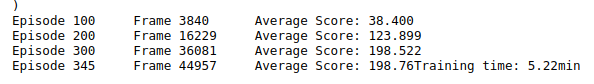

In [9]:
import pandas as pd
df=pd.DataFrame(QR)
df.to_csv('QR_CartPole_Result.csv')

In [12]:
df[2]

0       64.000000
1       46.500000
2       36.333333
3       38.000000
4       38.600000
          ...    
365    200.000000
366    200.000000
367    200.000000
368    200.000000
369    200.000000
Name: 2, Length: 370, dtype: float64

C:\Users\HP\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


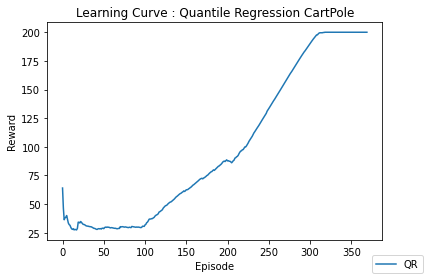

In [15]:
import matplotlib.pyplot as plt
fig=plt.figure()   
    
reward='QR_CartPole'
df.to_csv(reward+'.csv')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df[2],  label='QR')


plt.title('Learning Curve : Quantile Regression CartPole')

# agent.save('Model_dqn.h5')
fig.legend(loc='lower right')
fig.savefig(reward+'.png', dpi=100)
fig.show()   
        